<h1> Labeling analysis </h1>

**date**: 3. May 2023 

Let's investigate with photons are in the first 3 entries and which in the last 3.

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from uncertainties import unumpy as unp

In [2]:

def loss_flip_weighted(y_true, y_pred):
    bs = int(tf.size(y_true)/6) # batchsize
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = [tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL]
    sq = k.square((y_true - y_pred) / tf.transpose(weights))
    mse = k.sum(sq, axis=1)
    
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    sq_flipped = k.square((y_true - y_pred_flipped) / tf.transpose(weights))
    mse_flipped = k.sum(sq_flipped, axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss
    
def flip_output_weights(output):
    '''output is output of NN'''
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = np.ones((len(output), 6)) * np.array([ort_AL, ort_AL, E_AL, ort_AL, ort_AL, E_AL])
    #out_w = out/weights
    output_flipped = np.roll(output, 3, axis=1)
    mse = np.sum(np.square(output/weights-ipd.veri_truth/weights), axis=1)
    mse_flipped = np.sum(np.square(output_flipped/weights-ipd.veri_truth/weights), axis=1)
    ind_flip = np.where(mse_flipped<mse)
    output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)
    return output

# title
title = "st4_clusters5_place_inthemiddle" 

In [4]:
rootfile = uproot.open('./../stage5/stage5_clusters_2gamma.root')
ipd = hf.InputData_2photon(rootfile, min_dist=4, sort_cond='none')
ipd.form_cluster(random=False)
ipd.train_test_split()

Initialized object
Cutted  909177  clusters due to photon pair with distance smaller than  4  cm.
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  278.83145451545715 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [5]:
model= keras.models.load_model('models/model_st4_clusters5_place_inthemiddle', custom_objects={'loss_flip_weighted': loss_flip_weighted})
output = model.predict(ipd.clusters_v)
output_= flip_output_weights(output)
ev = hf.Evaluation_2photon(ipd, output)

<h2> let's make some histograms

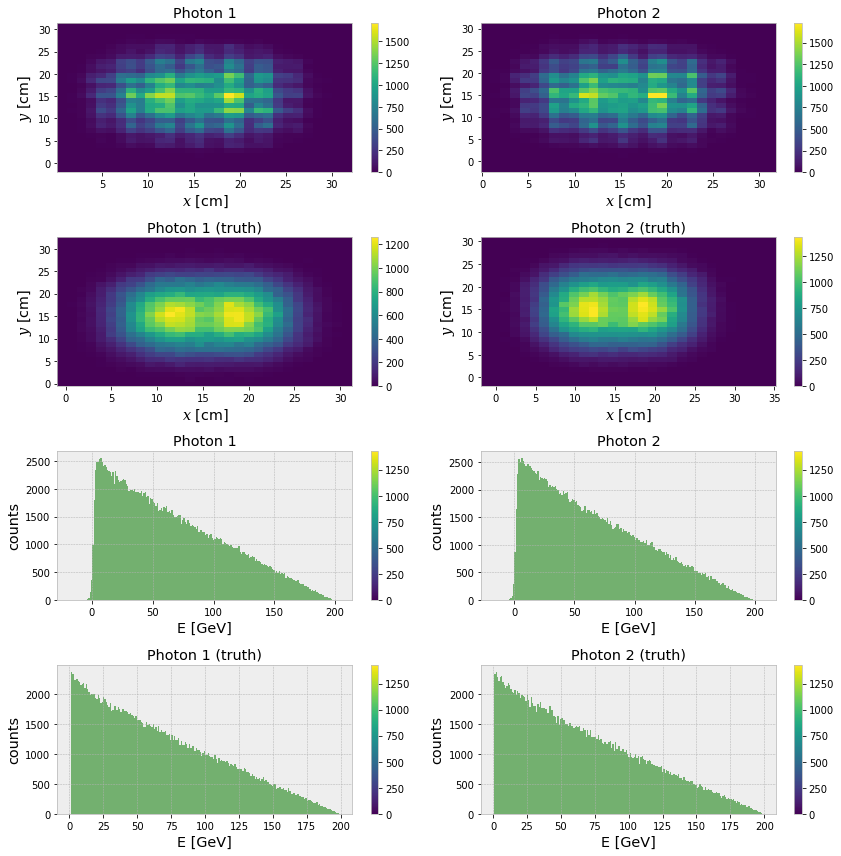

In [19]:
plt.style.use("standard_style.mplstyle")

fig = plt.figure(figsize=(12, 12))
bins=200
fig.add_subplot(4,2,1)
plt.hist2d(ev.x1, ev.y1, bins=30)
plt.title("Photon 1")
plt.colorbar()
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")

fig.add_subplot(4,2,2)
plt.hist2d(ev.x2, ev.y2, bins=30)
plt.title("Photon 2")
plt.colorbar()
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")

fig.add_subplot(4,2,3)
plt.hist2d(ev.x1_t, ev.y1_t, bins=30)
plt.title("Photon 1 (truth)")
plt.colorbar()
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")

fig.add_subplot(4,2,4)
plt.hist2d(ev.x2_t, ev.y2_t, bins=30)
plt.title("Photon 2 (truth)")
plt.colorbar()
plt.xlabel("$x$ [cm]")
plt.ylabel("$y$ [cm]")


fig.add_subplot(4,2,1+4)
plt.hist(ev.E1, bins=bins)
plt.title("Photon 1")
plt.colorbar()
plt.xlabel("E [GeV]")
plt.ylabel("counts")

fig.add_subplot(4,2,2+4)
plt.hist(ev.E2, bins=bins)
plt.title("Photon 2")
plt.colorbar()
plt.xlabel("E [GeV]")
plt.ylabel("counts")

fig.add_subplot(4,2,3+4)
plt.hist(ev.E1_t, bins=bins)
plt.title("Photon 1 (truth)")
plt.colorbar()
plt.xlabel("E [GeV]")
plt.ylabel("counts")

fig.add_subplot(4,2,4+4)
plt.hist(ev.E2_t, bins=bins)
plt.title("Photon 2 (truth)")
plt.colorbar()
plt.xlabel("E [GeV]")
plt.ylabel("counts")

plt.tight_layout()
plt.show()

In [ ]:
plt.